In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X[0]

array([ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
       -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613])

In [4]:
y[0:5]

array([151.,  75., 141., 206., 135.])

More info on diabetes dataset: https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset

In [5]:
from sklearn.linear_model import Lasso
reg = Lasso()
reg.fit(X,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [6]:
from sklearn.model_selection import cross_val_score
baseline = cross_val_score(reg, X,y, scoring='neg_mean_squared_error').mean()

In [7]:
baseline

-3850.836426532861

In [8]:
# Apply LASSO linear regression, as a function of alpha (=L1 regularization term) only.

def L(alpha):
    reg = Lasso(alpha)
    reg.fit(X,y)
    score = cross_val_score(reg, X,y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score   
    

**Goal:** Try different methods to find "the best" $\alpha$ that minimizes $\mathcal L(\alpha)$.


In [9]:
L(1)

array(-3850.83642653)

## Hyperparameter selection with GridSearch

In [10]:
alphas = np.linspace(1e-5, 1) # 50 points to try (by default)
Ls = [L(alpha) for alpha in alphas]

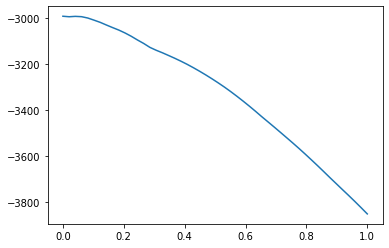

In [11]:
plt.plot(alphas, Ls)

## Hyperparameter selection with Random Search

In [12]:
alphas = np.random.uniform(low=1e-5, high=1, size=50)
Ls = [L(alpha) for alpha in sorted(alphas)]

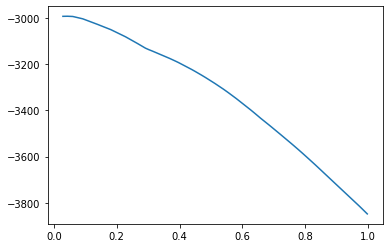

In [13]:
plt.plot(sorted(alphas), Ls)

### Scikit-specific


In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

In [15]:
# Random Search
param_dist = {'alpha': uniform(0,1)}
rs = RandomizedSearchCV(reg, param_distributions=param_dist, scoring='neg_mean_squared_error', n_iter=25)
rs.fit(X,y);

In [16]:
# Grid search
param_grid = {'alpha':np.linspace(1e35,1, 25)}
gs = GridSearchCV(reg, param_grid=param_grid, scoring='neg_mean_squared_error')
gs.fit(X,y);

In [17]:
# Bayesian Optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

bds = [{'name':'alpha', 'type':'continuous', 'domain':(0,2)}]

optimizer = BayesianOptimization(f=L, model_type='GP', acquisition_type='EI', domain=bds, maximize=True)
optimizer.run_optimization(max_iter=20)

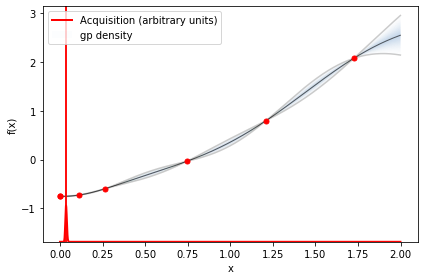

In [18]:
optimizer.plot_acquisition()

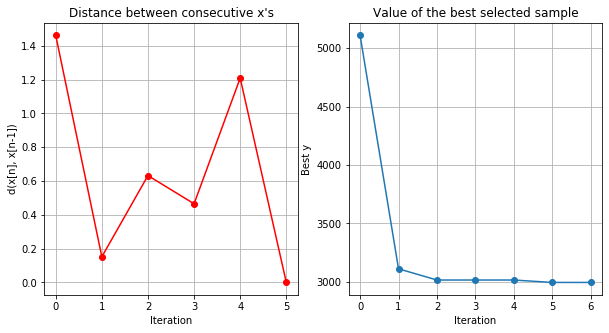

In [19]:
optimizer.plot_convergence()

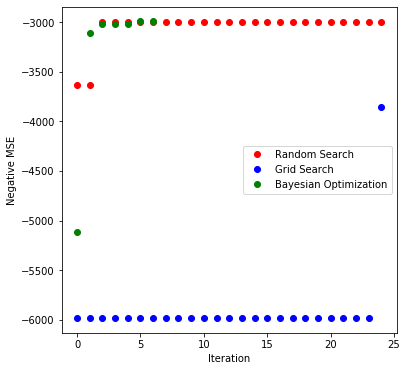

In [20]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(gs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

plt.figure(figsize=(6,6))
plt.plot(y_rs, 'ro', label='Random Search')
plt.plot(y_gs, 'bo', label='Grid Search')
plt.plot(y_bo, 'go', label='Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='right');